<h1 id="Segmentation">Segmentation<a class="anchor-link" href="#Segmentation"></a></h1> <br>

<font color = 'blue'>_Sudarsanan A K_ <br>
_SC21M063_ </font>

## Part 1 :  Implement Otsu thresholding algorithm (use minimization of within-class variance approach). Binarize the image according to this optimal threshold.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

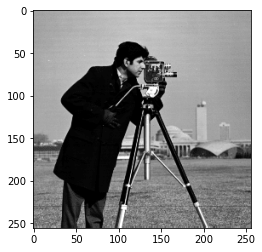

In [2]:
original_image = cv2.imread("data/cameraman.png", 0)
plt.imshow(original_image, cmap = 'gray');

Otsu's Threshold 82.267578125


Text(0.5, 1.0, 'Normalized Histogram of Original Image')

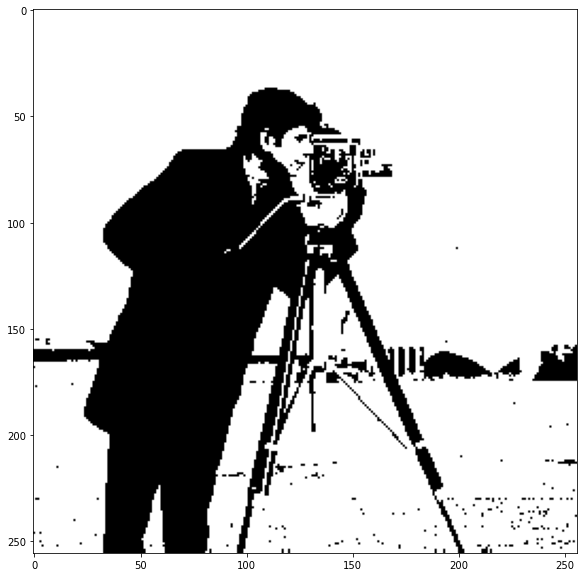

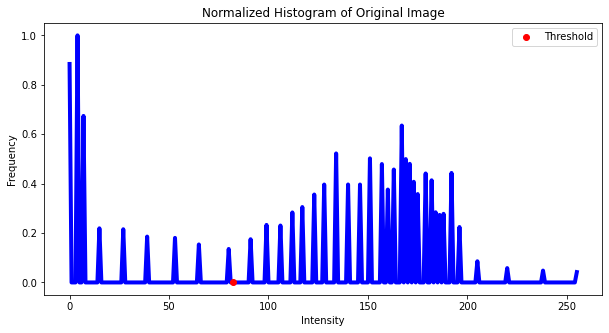

In [3]:
bins = 256
histogram, bin_edges = np.histogram(original_image, bins=bins)
histogram = np.divide(histogram.ravel(), histogram.max()) # normalization
bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.
weight1 = np.cumsum(histogram)
weight2 = np.cumsum(histogram[::-1])[::-1]
mean1 = np.cumsum(histogram * bin_mids) / weight1
mean2 = (np.cumsum((histogram * bin_mids)[::-1]) / weight2[::-1])[::-1]
# sigma_b
inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
index_of_max_val = np.argmax(inter_class_variance)
threshold = bin_mids[:-1][index_of_max_val]
print("Otsu's Threshold", threshold)
binary_image = np.zeros(np.shape(original_image))
# Thresholding
for i in range(np.shape(original_image)[0]):
    for j in range(np.shape(original_image)[1]):
        if original_image[i, j] < threshold:
            binary_image[i, j] = 0
        else:
            binary_image[i, j] = 1
plt.figure(figsize = (10 , 10))
plt.imshow(binary_image, cmap = 'gray');
fig, ax = plt.subplots(figsize = (10,5))
x = np.linspace(0, 255, 256)
ax.plot(x, histogram, 'b', linewidth = 4)
ax.plot(threshold, 0 ,'ro', label = 'Threshold')
ax.legend(loc = 'upper right')
ax.set_xlabel("Intensity")
ax.set_ylabel("Frequency")
ax.set_title("Normalized Histogram of Original Image")

## Part 2 :  Implement k-mean clustering segmentation. Allow the user to set an initial cluster center and then segment this region according to the similarity of colors or intensity.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
from scipy import  misc
from PIL import Image

In [2]:
def extract_features(image, d):
    w, h = image.shape[0:2]
    hsv_image = colors.rgb_to_hsv(image)
    num_points = w*h
    if d == 1:
        im_space = hsv_image[...,2]
    elif d == 2:
        im_space = hsv_image[...,0:2]
    elif d == 3:
        im_space = image
    else:
        exit('Not supported feature')
    feature_vector = np.reshape(im_space, (num_points,d)).T
    return feature_vector

In [3]:
def extract_segmented_image(cluster_out, clusters, image):
    w, h = image.shape[0:2]
    d, k = clusters.shape[0:2]
    clusterd_feature_space = np.zeros((len(cluster_out),clusters.shape[0])).T
    for c in range(k):
        idxs = np.where(cluster_out == c)
        for j in idxs[0]:
            clusterd_feature_space[:,j] = clusters[:,c]    
    im_space  = np.reshape(clusterd_feature_space.T, (w, h, d))
    if d == 1:
        im_space = im_space[...,0]
        segmented_image = im_space
    elif d == 2:
        hsv_image = colors.rgb_to_hsv(image)
        hsv_image[...,0:2] = im_space
        hsv_image[..., 2] /= np.max(hsv_image[...,2])
        segmented_image = colors.hsv_to_rgb(hsv_image)
    else:
        segmented_image = im_space
    return segmented_image

In [4]:
def k_means(image, k, iterations, d):
    #1. Construnct feature space
    w, h = image.shape[0:2]
    num_points = w*h
    # We have 2D feature space
    feature_space = extract_features(image, d)
    # 2. Getting Initial centers 
    idxs = np.round(num_points * np.random.rand(k))
    #Boundary condition
    idxs[np.where(idxs >= w*h)] -= 1
    initial_centers = np.zeros((d,k))
    for i in range(k):
        initial_centers[:,i] = feature_space[:,int(idxs[i])]
    clusters_centers = initial_centers
    # Initialize distance vector 
    dist = np.zeros((k,1))
    #cluster points determines cluster of each point in space
    cluster_points = np.zeros((num_points, 1))
    #3 - start clustering for number of iterations
    for j in range(iterations):
        #Cluster all points according min distance
        for l in range(num_points):
            #Get distance to all centers (Euclidean Distance)
            for m in range(k):
                dist[m] = np.sqrt(np.sum((feature_space[:,l]-clusters_centers[:,m])**2))
            #Select minimum one
            cluster_points[l] = np.argmin(dist)
        # Update centers of clusters according new points 
        for c in range(k):
            # Get points associated with that cluster
            idxs = np.where(cluster_points == c)
            points = feature_space[:,idxs[0]]
            # Get its new center 
            # Avoid division by zero
            if points.size > 0:
                clusters_centers[:,c] = np.mean(points, 1)
            else:
                idx =  np.round(num_points * np.random.rand())
                clusters_centers[:,c] = feature_space[:,int(idx)]
        segmented_image = extract_segmented_image(cluster_points, clusters_centers, image)
        return segmented_image

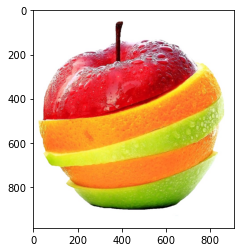

In [22]:
#Load the image
image = plt.imread('data/image.jpg')
# Rescale image down for speedup    
#image = np.array(Image.fromarray(image).resize(size = (150, 150))) 
#Show original Image
plt.figure('Original Image')
plt.imshow(image)

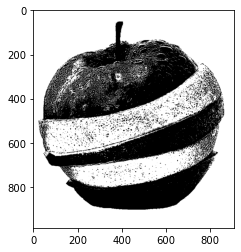

In [23]:
# 1D Feature Space
#Apply k means segmentation and show the result
d = 1
k = 5
iterations = 10
segmented_image = k_means(image, k, N, d)
plt.figure('Segmented image')
plt.set_cmap('gray')
plt.imshow(segmented_image)

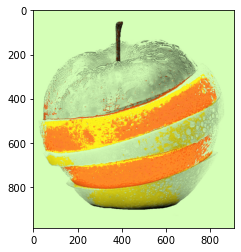

In [24]:
# 2D Feature Space
d = 2
k = 5
iterations = 10
segmented_image = k_means(image, k, N, d)
plt.figure('Segmented image')
plt.set_cmap('gray')
plt.imshow(segmented_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


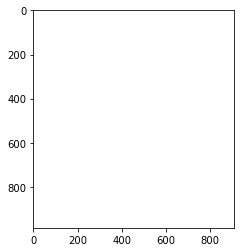

In [25]:
# 3D Feature Space
d = 3
k = 5
iterations = 10
segmented_image = k_means(image, d, N, d)
plt.figure('Segmented image')
plt.set_cmap('gray')
plt.imshow(segmented_image)

## Part 3 : Implement mean shift segmentation using a flat kernel. Segment image based on 1D, 2D, and 3D feature spaces.

Alogorithm : Extract feature space from image <br>
While number of unvisited points > 0 <br>
$"&embp"$    Select a random point in feature space (Initial mean) <br>
$"&embp"$    While true: <br>
$"&embp"$    Get distance between mean and all points in feature space<br>
$"&embp"$    For uniform window, select points in the range of specified bandwidth and track that points<br>
$"&embp"$$"&embp"$    Get the new mean, it is the mean of points within bandwidth<br>
$"&embp"$    if distance between new and old means < threshold:<br>
$"&embp"$$"&embp"$      cluster all tracked points to new mean <br>
$"&embp"$$"&embp"$        update number of visited points <br>
$"&embp"$$"&embp"$        break <br><br>
merging clusters<br>
Extract feature space from image<br>
While number of unvisited points > 0<br>
   $"&embp"$ Select a random point in feature space (Initial mean)<br>
   $"&embp"$While true: <br>
   $"&embp"$ Get distance between mean and all points in feature space<br>
   $"&embp"$ For uniform window, select points in the range of specified bandwidth and track that points<br>
   $"&embp"$Get the new mean, it is the mean of points within bandwidth<br>
   $"&embp"$if distance between new and old means < threshold:<br>
   $"&embp"$$"&embp"$   for c in clusters:<br>
            $"&embp"$$"&embp"$$"&embp"$#Check merge condition<br>
            $"&embp"$$"&embp"$$"&embp"$if distance(c, center) < 0.5* Bandwidth:<br>
                $"&embp"$$"&embp"$$"&embp"$$"&embp"$mean of cluster c = 0.5*distance(c,center)<br>
               $"&embp"$$"&embp"$$"&embp"$$"&embp"$ cluster all tracked points to cluster c<br>
        $"&embp"$$"&embp"$ #No merge <br>
        $"&embp"$ $"&embp"$cluster all tracked points to new mean <br>
        $"&embp"$ $"&embp"$#Update visited points<br>
        $"&embp"$ $"&embp"$update number of visited points <br>
       $"&embp"$ $"&embp"$ break<br>